In [779]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF
import seaborn as sns
sns.set()
rcParams['figure.figsize']=(15, 8)
plt.style.use('ggplot')

In [780]:
EVENTS_FILE = "football-events/events.csv"
GAME_INFO_FILE = "football-events/ginf.csv"

In [781]:
game_info_df = pd.read_csv(GAME_INFO_FILE)
game_info_df.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [782]:
# Show leagues available
game_info_df['league'].unique()

array(['D1', 'F1', 'E0', 'SP1', 'I1'], dtype=object)

In [783]:
game_info_df = game_info_df[game_info_df['league'] == 'E0']

In [784]:
home_teams = game_info_df['ht'].unique()
away_teams = game_info_df['at'].unique()
print("Nb teams home: %d" % home_teams.size)
print("Nb teams away: %d" % away_teams.size)

Nb teams home: 31
Nb teams away: 31


In [785]:
to_remove = []
for i,team in enumerate(away_teams):
    if not team in home_teams:
        print(i, team)
        to_remove.append(i)

In [786]:
away_teams = np.delete(away_teams, to_remove)
print("Nb teams home: %d" % home_teams.size)
print("Nb teams away: %d" % away_teams.size)

Nb teams home: 31
Nb teams away: 31


In [787]:
#home_teams = np.sort(home_teams)
#away_teams = np.sort(away_teams)
away_teams = home_teams
assert(np.array_equal(home_teams, away_teams))

teams_to_idx = {}
for i, team in enumerate(home_teams):
    teams_to_idx[team] = i

In [788]:
X = np.identity(home_teams.size)
counts = np.zeros((home_teams.size, away_teams.size))
print(X.shape)
print(counts.shape)

(31, 31)
(31, 31)


In [789]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [790]:
for index, row in game_info_df.iterrows():
    home_team = row['ht']
    away_team = row['at']
    home_score = row['fthg']
    away_score = row['ftag']
    prob_home_team_win = sigmoid(home_score - away_score)
    if not home_team in teams_to_idx or not away_team in teams_to_idx:
        continue
        
    home_idx = teams_to_idx[home_team]
    away_idx = teams_to_idx[away_team]
    counts[home_idx, away_idx] += 1
    X[home_idx, away_idx] += prob_home_team_win

In [791]:
np.seterr(divide='ignore')
X = np.divide(X, counts)
np.seterr(divide='raise')
X[X == np.inf] = np.nan

/Users/valentin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [792]:
# Sort by sum of col -> for away_teams
teams_with_sum_col = []
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 1.0
temp_X
for i in range(temp_X.shape[1]):
    teams_with_sum_col.append((away_teams[i], np.sum(temp_X[:, i])))

teams_with_sum_col.sort(key=lambda pair: -pair[1])
away_teams = list(map(lambda pair: pair[0], teams_with_sum_col))

# Sort by sum of row -> for home_teams
teams_with_sum_row = []
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 0.0
for i in range(temp_X.shape[0]):
    teams_with_sum_row.append((home_teams[i], np.sum(temp_X[i, :])))
    
teams_with_sum_row.sort(key=lambda pair: -pair[1])
home_teams = list(map(lambda pair: pair[0], teams_with_sum_row))

In [793]:
# Sort X by rows' sum, then by columns' sum
temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 0.0
X = X[np.argsort(-temp_X.sum(axis=1))]

temp_X = X.copy()
temp_X[np.isnan(temp_X)] = 1.0
X = X[:, np.argsort(-temp_X.sum(axis=0))]

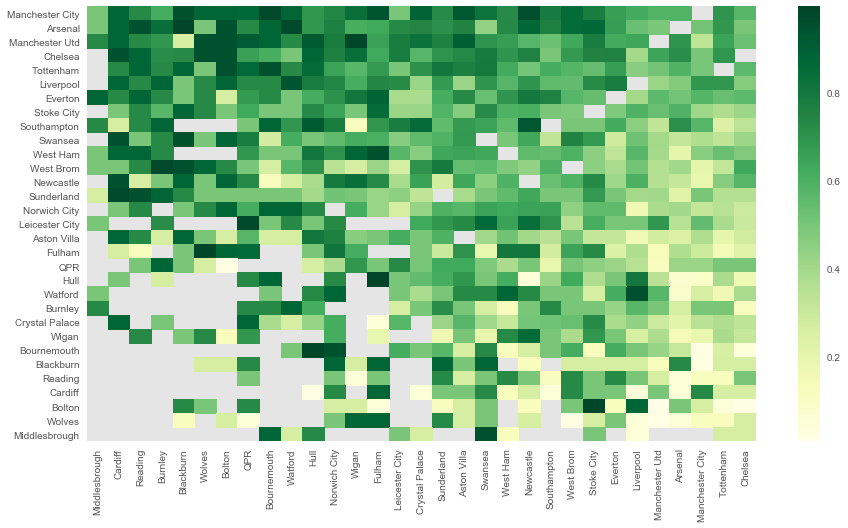

In [794]:
#X[X == 0] = 0.5
#plt.imshow(X, cmap='hot', interpolation='nearest')
sns.heatmap(X, xticklabels=away_teams, yticklabels=home_teams, cmap="YlGn")

In [795]:
mean = np.nanmean(X)
print(mean)

0.552765734275


In [796]:
# What to do with NaNs??
X[np.isnan(X)] = mean

model = NMF(n_components=None, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [797]:
model

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=None, random_state=0, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [798]:
W.shape

(31, 31)

## t-SNE

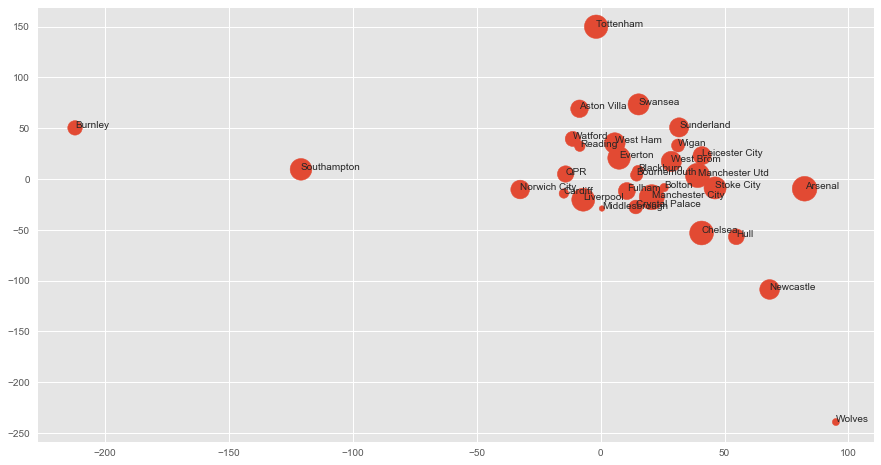

In [799]:
# Latent variables for home_teams
W_embedded = TSNE(n_components=2).fit_transform(W)
x = W_embedded[:,0]
y = W_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

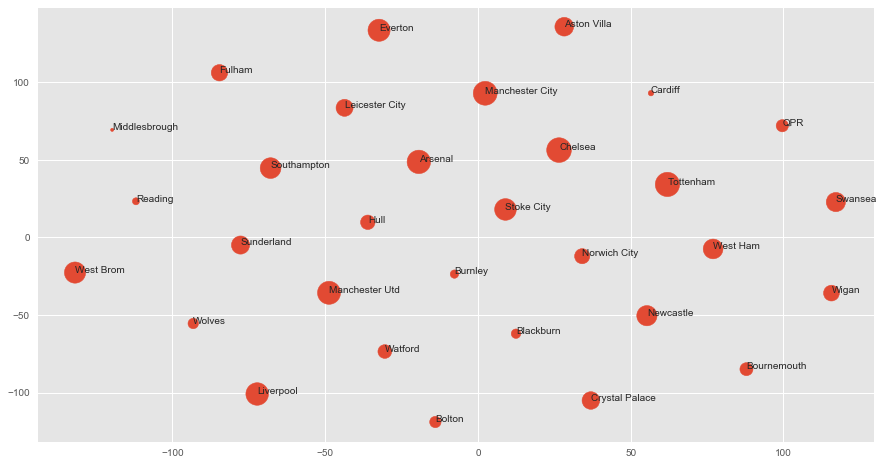

In [800]:
# Latent variables for away_teams
H_embedded = TSNE(n_components=2).fit_transform(H.T)
x = H_embedded[:,0]
y = H_embedded[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(home_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))

## PCA

[ 0.34365266  0.12923923]


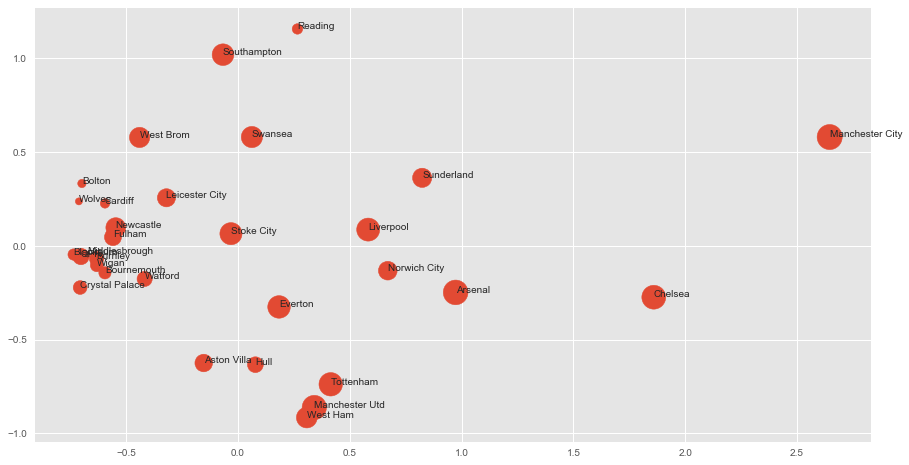

In [813]:
# Latent variables for home_teams
pca_W = PCA(n_components=2)
new_W = pca_W.fit_transform(W)
print(pca_W.explained_variance_ratio_)
x = new_W[:,0]
y = new_W[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10+20*len(home_teams), 10, -20))
for i, team_name in enumerate(home_teams):
    ax.annotate(team_name, (x[i],y[i]))

[ 0.91252074  0.02039064]


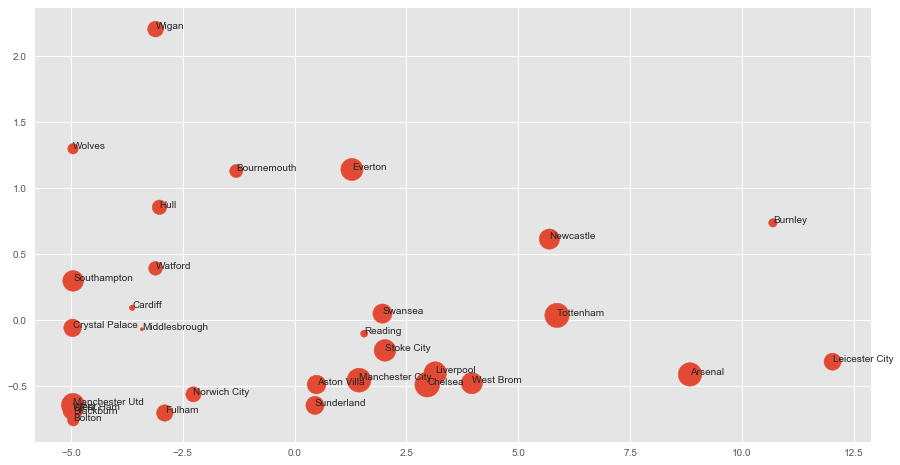

In [802]:
# Latent variables for away_teams
pca_H = PCA(n_components=2)
new_H = pca_H.fit_transform(H.T)
print(pca_H.explained_variance_ratio_)
x = new_H[:,0]
y = new_H[:,1]
fig, ax = plt.subplots()
ax.scatter(x, y, s=np.arange(10, 10+20*len(away_teams), 20))
for i, team_name in enumerate(away_teams):
    ax.annotate(team_name, (x[i], y[i]))